# ExperimentalDesign

In this notebook we will be using a random-search algorithm to choose the optimal design for our experiment. Creating random designs (without evaluation) in fMRI world often leads to under powered designs because the randomisation does not consider the lagged hemodynamic response and how one trial's response may bleed into another trial's response. This is more of a concern in event related designs, but still something to consider in block designs as well.

The video below from Jeanette Mumford helps illuminate task design and to consider what we want from our design

### Learning Objectives
- Describe the difference between estimation and detection
- Understand why choosing a random design can lead to reduced power
- State the rule of thumb for a good variance inflation factor (or variance reduction factor)
- Learn the options of optseq2 (freesurfer tool) and how to use the tool to design an efficient experimental design
- Make an experimental design for your group project

In [62]:
# import necessary packages
%matplotlib inline
import pandas as pd

In [1]:
from IPython.display import HTML

# If you don't hear this video and you're viewing from virtual machine, you may need to 
# set up audio in virtual machine settings (you'll need to do this when the machine is powered off)
# Jeanette Mumford video
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/FD4ztsoYvSY" frameborder="0" gesture="media" allow="encrypted-media" allowfullscreen></iframe>')



## Building An Experiment
In lab today we will be considering the flanker experiment we covered in the previous lab (07-Lab).

![flanker](img/task.png)

The relevant parameters are:
- the number of stimuli (3)
- the duration of the stimulus (200 ms)
- the duration of the response period (1800 ms) (immediately after the stimulus)
- the number of presentations for each stimulus (40)
- the length of the scan (315 volumes = 630 seconds)
- the contrast(s) of interest (incongruent - congruent).

In [2]:
%%bash
# display the help of optseq for us to see all the parameters
optseq2 --help

USAGE: optseq2 

Data Acquistion Parameters

  --ntp Ntp : number of time points
  --tr TR : temporal resolution of acquisition (in sec)
  --tprescan t : start events t sec before first acquisition

Event Response and Nuisance Descriptors

  --psdwin psdmin psdmax <dPSD> : PSD window specifications
  --ev label duration nrepetitions
  --repvar pct <per-evt>: allow nrepetitions to vary by +/- percent
  --polyfit order  
  --tnullmin tnullmin : limit min null duration to tnullmin sec  
  --tnullmax tnullmax : limit max null duration to tnullmax sec  

Searching and Cost Parameters

  --nsearch n : search over n schedules
  --tsearch t : search for t hours
  --focb    n : pre-optimize first order counter-balancing
  --ar1 rho : optimize assuming whitening with AR1
  --pen alpha T dtmin: penalize for presentations being too close
  --evc c1 c2 ... cN : event contrast
  --cost name <params>: eff, vrfavg, vrfavgstd

  --sumdelays : sum delays when forming contrast matrix
  --seed seedval : i

## Relevant optseq2 Parameters
#### --ntp 315
 - DOC: Number of time points to be acquired during the scan.  This should be
for one 'run' not for the entire session. The Total Scanning Time
is the number of time points times the TR plus the prescan period,
ie, tScanTot = Ntp*TR+tPreScan. 
- ANS: The flanker scan has 315 volumes.

#### --tr 2
 - DOC: Time between functional volumes (in seconds).
 - ANS: For this scan the TR is 2 seconds
 
#### --psdwin 0 20 0.2
 - DOC: Specifications for the FIR event response window. It will be assumed that 
the entire response can be captured within this window. PSDMin is the 
minimum PostStimulus Delay (PSD), PSDMax is the maximum PSD. dPSD 
is the sampling interval within the window. dPSD is optional; if 
left unset, it will default to the TR. dPSD controls how finely spaced  
the event onsets can be scheduled (ie, the onsets will only appear at  
integer multiples of the dPSD). 
 -  ANS: I've set the relevant hemodynamic response period to be between 0 and 20 seconds.
    This means a stimulus at 8 seconds will have an influence
    on the design matrix from 8 - 28 seconds. Real hemodynamic responses can have a residual
    effect up to 36 seconds after the stimulus, but the majority of the effect *should* be
    done after 20 seconds. The third parameter is the resolution of the design matrix.
    This has to be as small as the stimulus duration or a factor smaller (e.g. 0.1, 0.05, etc).

#### --ev con 0.2 40 --ev inc 0.2 40 --ev neu 0.2 40
- DOC: Event Type specification. The label is just a text label (which may be 
more informative than a numeric id). Duration is the number of seconds 
that the stimulus will be presented; it should be an integer multiple 
of the dPSD (see --psdwin). Nrepetitions is the number of times that 
this event type will be presented during the course of the run. The 
number of repetitions can be optimized using the --repvar option. Use 
a different --ev flag for each event type. NOTE: DO NOT INCLUDE THE 
NULL STIMULUS AS AN EVENT TYPE.  The total stimulation time, tStimTot, 
equals the product of the duration and the number of repetitions 
summed over all the events. It should be obvious that the total 
stimulation time must be less than the total scanning time. 
- ANS: The flanker task has three conditions: congruent (con), 
  incongruent (inc), and neutral (neu), each of the stimuli
  will be presented for 0.2 seconds (200 milli-seconds) and repeated
  40 times each.

#### --tnullmin 3.8
- DOC: Force the NULL stimulus to be at least tNullMin sec between stimuli.
Note that this means that the stimulus duration + tNullMin must be
an integer multiple of the dPSD.
- ANS: This enforces participants will have the 1.8 second period to respond
  after the 0.2 second stimulus, meaning at least 2 seconds of "rest" will be given
  to participants after each trial.

#### --tnullmax 20
- DOC: Limit the maximum duration of the NULL stimulus to be tNullMax sec.
 Note: it may not be possible for a given parameter set to keep the NULL 
stimulus below a certain amount. In this case, the following error 
message will be printed out 'ERROR: could not enforce tNullMax'. By
default, tNullMax is infinite. 
- ANS: A pratical limitation to constrain the creation of designs
  with loooong rest periods between trials.

#### --nsearch 1000
- DOC: Search over Nsearch iterations. optseq will randomly construct Nsearch 
schedules, compute the cost of each one, and keep the ones with the 
highest cost. It is not permitted to specify both Nsearch and Tsearch. 
- ANS: I'm generating 1,000 designs for time's sake, you will want 
  a much larger number (i.e. 10,000 or even 100,000) for actual design generation
  
#### --evc -1 1 0
- DOC: Optimize based on a contrast of the event types. Ci is the contrast 
weight for event type i. There must be as many weights as event types. 
Weights are NOT renormalized such that they sum to 1. 
- ANS: each number corresponds to each `--ev` I've specified in the order I specified them
  In this case the -1 corresponds to the congruent condition, 1 corresponds to the incongruent condition
  and 0 refers to the neutral condition. The contrast in words means (incongruent - congruent).

#### --seed 123
- DOC: Initialize the random number generator to seedval. If no seedval is 
specified, then one will be picked based on the time of day. optseq2 
uses drand48(). 
- ANS: To make sure my analysis is reproducible

#### --nkeep 5
- DOC: Save nKeep of the best schedules. Increasing this number does not 
substantially increase the search time, so it is a good idea to  
specify more than you think you will need. 
- ANS: keeping the top five (in case I want to randomise which version I use across participants)

#### --o flanker_stims
- DOC:Save schedules in outstem-RRR.par, where RRR is the 3-digit 
zero-padded schedule rank number (there will be nKeep of them). 
The schedules will be saved in the Paradigm File Format (see below).
- ANS: A useful output name

In [23]:
%%bash
optseq2 \
--tprescan -8 `# number of seconds to wait before showing stimuli (allows scanner to reach steady state)` \
--ntp 315 `# number of volumes in the experiment` \
--tr 2 `# repetition time (how long it takes to scan the entire brain once)` \
--psdwin 0 20 0.2 `# The first two numbers give the time range of the HRF, and the third is resolution of the design` \
--ev con 0.2 40 `# congruent (con: 0.2 second duration, 40 repetitions)` \
--ev inc 0.2 40 `# incongruent (inc: 0.2 second duration, 40 repetitions)` \
--ev neu 0.2 40 `# neutral (neu: 0.2 second duration, 40 repetitions)` \
--tnullmin 3.8 `# The minimum time between presentations of stimuli. 3.8 - 1.8 (response period) = 2.0 seconds (the real amount of non-processing time)` \
--tnullmax 20 `# The maximum time between presentations of stimuli` \
--nsearch 1000 `# The number of designs to consider` \
--evc -1 1 0 `# The contrast of interest for the experiment (inc - con)` \
--seed 123 `# set random seed to get consistent results` \
--nkeep 5 `# keep the top five designs` \
--o flanker_stimuli_orig `# the output base name` &> /dev/null

optseq2
$Id: optseq2.c,v 2.14 2008/03/10 13:35:23 nicks Exp $
NoSearch  = 0
nSearch  = 1000
nKeep    = 5
PctUpdate  = 10.000000
nCB1Opt  = 0
seed     = 123
Ntp  = 315
TR   = 2
TPreScan   = -8
PSD Window   = 0 20 0.2
nEvTypes = 3
EvNo    Label Duration nRepsNom
 1        con  0.200   40
 2        inc  0.200   40
 3        neu  0.200   40
PctVarEvReps = 0
VarEvRepsPerCond = 0
PolyOrder = -1
tNullMax = 20
tNullMin = 3.8
outstem = flanker_stimuli
AR1 = 0
No refractory penalty
Cost = eff
OutStem = flanker_stimuli
Summary File = flanker_stimuli.sum
nTaskAvgs = 300
C Contrast Matrix ----------------------
-1.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0

/usr/pubsw/packages/vxl/1.8.0/vxl-1.8.0/core/vnl/algo/vnl_qr.txx: vnl_qr<T>::solve() : matrix is rank-deficient by 194
/usr/pubsw/packages/vxl/1.8.0/vxl-1.8.0/core/vnl/algo/vnl_qr.txx: vnl_qr<T>::solve() : matrix is rank-deficient by 194
/usr/pubsw/packages/vxl/1.8.0/vxl-1.8.0/core/vnl/algo/vnl_qr.txx: vnl_qr<T>::solve() : matrix is rank-deficient by 194
/usr/pubsw/packages/vxl/1.8.0/vxl-1.8.0/core/vnl/algo/vnl_qr.txx: vnl_qr<T>::solve() : matrix is rank-deficient by 194
/usr/pubsw/packages/vxl/1.8.0/vxl-1.8.0/core/vnl/algo/vnl_qr.txx: vnl_qr<T>::solve() : matrix is rank-deficient by 194
/usr/pubsw/packages/vxl/1.8.0/vxl-1.8.0/core/vnl/algo/vnl_qr.txx: vnl_qr<T>::solve() : matrix is rank-deficient by 194
/usr/pubsw/packages/vxl/1.8.0/vxl-1.8.0/core/vnl/algo/vnl_qr.txx: vnl_qr<T>::solve() : matrix is rank-deficient by 194
/usr/pubsw/packages/vxl/1.8.0/vxl-1.8.0/core/vnl/algo/vnl_qr.txx: vnl_qr<T>::solve() : matrix is rank-deficient by 194
/usr/pubsw/packages/vxl/1.8.0/vxl-1.8.0/core/vnl

,Rank,Cost,ZCost,NthIter,Eff,CB1Err,VRFAvg,VRFStd,VRFMin,VRFMax,VRFRng,IXtXErr
0,1,0.0009,0.745,383,0.001,0.113889,0.12,0.07,0.02,0.34,0.32,42041.68
1,2,0.0008,0.704,257,0.001,0.130556,0.11,0.06,0.02,0.33,0.31,42453.02
2,3,0.0008,0.701,238,0.001,0.125000,0.12,0.07,0.02,0.35,0.33,42212.75
3,4,0.0008,0.700,722,0.001,0.086111,0.10,0.05,0.03,0.26,0.24,42136.41
4,5,0.0008,0.698,84,0.001,0.213889,0.09,0.04,0.03,0.19,0.17,41992.77


,Rank,Cost,ZCost,NthIter,Eff,CB1Err,VRFAvg,VRFStd,VRFMin,VRFMax,VRFRng,IXtXErr
count,5.000000,5.000000,5.000000,5.000000,5.000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,3.000000,0.000820,0.709600,336.800000,0.001,0.133889,0.108000,0.058000,0.024000,0.294000,0.274000,42167.326000
std,1.581139,0.000045,0.019907,240.078529,0.000,0.047888,0.013038,0.013038,0.005477,0.068044,0.068044,180.898393
min,1.000000,0.000800,0.698000,84.000000,0.001,0.086111,0.090000,0.040000,0.020000,0.190000,0.170000,41992.770000
25%,2.000000,0.000800,0.700000,238.000000,0.001,0.113889,0.100000,0.050000,0.020000,0.260000,0.240000,42041.680000
50%,3.000000,0.000800,0.701000,257.000000,0.001,0.125000,0.110000,0.060000,0.020000,0.330000,0.310000,42136.410000
75%,4.000000,0.000800,0.704000,383.000000,0.001,0.130556,0.120000,0.070000,0.030000,0.340000,0.320000,42212.750000
max,5.000000,0.000900,0.745000,722.000000,0.001,0.213889,0.120000,0.070000,0.030000,0.350000,0.330000,42453.020000


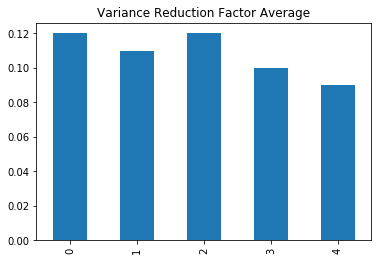

In [74]:


# open and read the summary file
def parse_optseq_summary(summary_file):
    with open(summary_file) as sf:
        n = -1
        # output collector in a list
        outer_lst = []
        # for each line
        for line in sf:
            # We are interested the line starting Rank and the five lines after that
            # representing the five designs we made
            if line.startswith("Rank"):
                n = 5
            # if the previous statement set n to 5 store the current and the next 
            # five lines into a list.
            if n >= 0:
                # remove the newline character, split by spaces, and remove null string elements.
                outer_lst.append([x for x in line.replace('\n', '').split(' ') if x is not ''])
                n -= 1
    return outer_lst

# the summary file that contains useful information about the designs
sum_file = 'flanker_stimuli_orig.sum'
# run the function
optseq_info = parse_optseq_summary(summary_file)
# the top list contains the headers for the dataframe
headers = optseq_info.pop(0)

# set the dataframe
df_orig = pd.DataFrame(optseq_info, columns=headers)
# make the contents numeric (were strings)
df_orig = df_orig.apply(lambda x: pd.to_numeric(x))
# display the first five elements (which are coincidently all the elements)
display(df_orig.head())
display(df_orig.describe())
# plot the Variance Reduction Factor
df_orig['VRFAvg'].plot.bar(title='Variance Reduction Factor Average', x='designs')


### Variance Reduction Factors (VRF)
This is a measure of how correlated the regressors (e.g. con, inc, and neu) are with each other. For example, if a congruent trial always followed 2 seconds after an incongruent trial the regressors would be highly correlated resulting in a very low variance reduction factor. Each condition (e.g. congruent, incongruent, and neutral) will have their own variance reduction factor. If $i$ stands for a particular condition $i$ (which can take the value of congruent, incongruent, or neutral in this instance), and $n$ represents the number of conditions (in this case 3), then we can calculate the average variance reduction factor like so:

$$1/n\int\limits_{i=1}^n 1 - R_i^2$$

Where $R_i^2$ is the r-squared component for that particular condition. In other words, $R_i^2$ measures the amount of variance in condition $i$ that can be explained by the other conditions. To give some intuition, a small variance reduction factor means the conditions are highly correlated with each other $R^2 = 0.99; 1 - R^2 = 0.01$, whereas a small variance reduction factor means the conditions are largely independent $R^2 = 0.01; 1 - R^2 = 0.99$. Unfortunately, outside of optseq, people often use variance inflation factor (VIF) when describing colinearity. Thankfully, the average variance inflation factor equation is just the inverse of the variance reduction factor equation.

$$1/n\int\limits_{i=1}^n 1/(1 - R_i^2)$$

Jeanette Mumford gives the rule of thumb the average VIF should ideally be under 5 or just under 10 if there are certain design constraints. So writing those in terms of variance reduction factors, they should be greater than 0.2, or at least greater than 0.1 in a pinch.

### VIF RULE OF THUMB
- VIF < 5 (or 10)

### VRF RULE OF THUMB
- VRF > 0.2 (or 0.1)


### Optseq2 Resources
- [optseq2 website](http://surfer.nmr.mgh.harvard.edu/optseq/)
- [Andrew Jahn Tutorial](https://www.youtube.com/watch?v=MIx_PN4FkKk)


### Other Resources
- [Excellent Practical Guide to Study Design](http://imaging.mrc-cbu.cam.ac.uk/imaging/DesignEfficiency)

## Practice Problems

1a) When we set `psdwin 0 20 0.2`, we essentially told optseq2 to smear the stimulus to have an impact on the design for 20 seconds (as opposed to 0.2 seconds). What do you think would happen if we instead set `psdwin 0 4 0.2`. How would you predict this would impact the VRF (or inversely the VIF)? 

:Prediction Here:

In [ ]:
# Code Here

1b) Compare the VRFs you got from 1a with the VRFs calculated from class, you can graph them both or use the describe method on the dataframe (e.g. `df_orig.describe()`)

In [ ]:
# Code Here

:Describe Results:

2) With your group, think up of a experiment and come up with the optseq2 command to optimize your experimental design (remember to set `--nsearch 10000`)

In [ ]:
# Code Here